The problem number 6.9.32

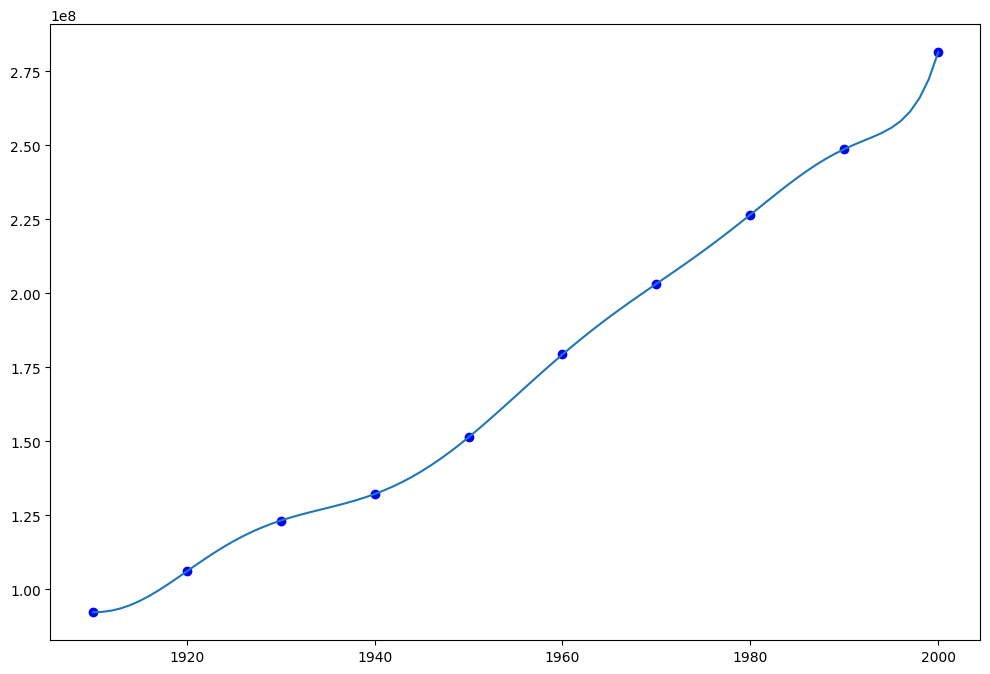

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
np.y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906])

def divided_diff(x, y):
    n = len(x)
    coeficient = np.zeros([n, n])
    #first column is our y, that we have
    coeficient[:, 0] = y

    for j in range(1, n):
        for i in range(n - j):
            coeficient[i][j] = (coeficient[i + 1][j - 1] - coeficient[i][j - 1]) / (x[i + j] - x[i])
    return coeficient

def newton_poly(coef, x_data, x):

    n = len(x_data) - 1 
    p = coef[n]
    for k in range(1,n+1):
        p = coef[n-k] + (x -x_data[n-k])*p
    return p
a_s = divided_diff(np.x, np.y)[0, :]
x_new = np.arange(1910, 2001, 1)
y_new = newton_poly(a_s, np.x, x_new)
plt.figure(figsize = (12, 8))
plt.plot(np.x, np.y, 'bo')
plt.plot(x_new, y_new)